# Imports

In [31]:
import numpy as np
import pandas as pd
from pulsee.operators import * 
from pulsee.simulation import *
import qutip as qt
import matplotlib.pyplot as plt

# Parameters

In [84]:
qn = 3/2
gr = 11.26
b0 = 10.
e2qQ = 0.5

spin_par = {'quantum number' : qn,
			'gamma/2pi' : gr}

zeem_par = {'field magnitude' : b0,
			'theta_z' : 0,
			'phi_z' : 0}

In [66]:
# etas = np.linspace(0, 1, 4)
etas = [1]

# Simulation
Define simulation code which we will run with different solvers:

In [92]:
def simulate(solver):

    # Fourier transforms for each eta
    fts = []

    for eta in etas:
        quad_par = {'coupling constant' : e2qQ,
                    'asymmetry parameter' : eta,
                    'alpha_q' : 0.,
                    'beta_q' : math.pi/2*0,
                    'gamma_q' : 0.}

        b1 = 1e-2 * b0

        mode = pd.DataFrame([(2 * np.pi * gr * b0, 2 * b1, 0., math.pi/2, 0)], 
                            columns=['frequency', 'amplitude', 'phase', 'theta_p', 'phi_p'])

        RRF_par = {'nu_RRF': 2 * np.pi * gr * b0,
                    'theta_RRF': math.pi,
                    'phi_RRF': 0.}

        spin, h_unperturbed, dm_initial = nuclear_system_setup(spin_par, quad_par=quad_par, 
                                            zeem_par=zeem_par, initial_state='canonical')

        print(np.round(dm_initial.full(), 3))
        opts = Options(atol=1e-10, rtol=1e-10, rhs_reuse=False, nsteps=30000)
        dm_evolved = evolve(spin, h_unperturbed, dm_initial, solver=solver, \
                            mode=mode, pulse_time=1 / (2 * b1), \
                            picture='IP', n_points=10, opts=opts)

        print(np.round(dm_evolved.full(), 3))
        t, FID = FID_signal(spin, h_unperturbed, dm_evolved, acquisition_time=50, \
                            T2=10, reference_frequency=0, n_points=750)


        f, ft = fourier_transform_signal(FID, t, padding=10)
        fts.append([eta, f, ft, t, FID])
    return fts

Run simulations with Magnus solver and QuTiP's [master equation solver](https://qutip.org/docs/latest/modules/qutip/mesolve.html#mesolve):

In [87]:
fts_magnus = simulate('magnus')

[[ 1.+0.j  0.+0.j -0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
[[0.082+0.j    0.01 -0.15j  0.034-0.053j 0.001-0.221j]
 [0.01 +0.15j  0.275+0.j    0.1  +0.055j 0.404-0.024j]
 [0.034+0.053j 0.1  -0.055j 0.048+0.j    0.142-0.09j ]
 [0.001+0.221j 0.404+0.024j 0.142+0.09j  0.595+0.j   ]]


In [93]:
fts_mesolve = simulate('mesolve')

[[ 1.+0.j  0.+0.j -0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
[[ 0.38 +0.j    -0.065+0.264j  0.108-0.167j  0.136-0.322j]
 [-0.065-0.264j  0.194-0.j    -0.135-0.046j -0.247-0.039j]
 [ 0.108+0.167j -0.135+0.046j  0.104+0.j     0.18 -0.031j]
 [ 0.136+0.322j -0.247+0.039j  0.18 +0.031j  0.321-0.j   ]]


Simulate with exact diagonalization approach:

In [50]:
fts_ed = [] 

for eta in etas:
	quad_par = {'coupling constant' : e2qQ,
				'asymmetry parameter' : eta,
				'alpha_q' : 0.,
				'beta_q' : math.pi/2,
				'gamma_q' : 0.}

	b1 = 1e-2 * b0

	RRF_par = {'nu_RRF': 2 * np.pi * gr * b0,
				'theta_RRF': math.pi,
				'phi_RRF': 0.}

# 	dm_initial = Qobj([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
	spin, h_unperturbed, dm_initial = nuclear_system_setup(spin_par, quad_par=quad_par, 
										zeem_par=zeem_par, initial_state='canonical')



	t = np.linspace(0, 50, 100) # 50 second acquisition time, 1000 data points

	ix, iy, iz = qt.spin_J_set(3 / 2)
	rot_dm = apply_rot_pulse(dm_initial, 1 / (4 * gr * b1), ix) # rotate about x axis
	dm_evolved, e_ops = ed_evolve(h_unperturbed, rot_dm, spin, t, e_ops=[], fid=True)

	FID = e_ops[0]

	f, ft = fourier_transform_signal(FID, t, padding=10)
	fts_ed.append([eta, f, ft])


# Plots
Plot magnus solution:

/home/lzawbrito/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


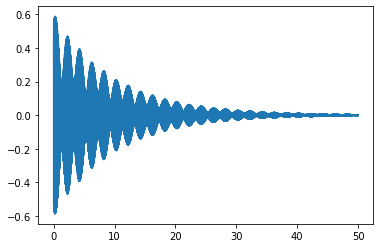

In [88]:
fig, ax = plt.subplots() 
for eta, f, ft, t, fid in fts_magnus: 
	plt.plot(t, fid)

# ax.set_xlim(0, 0.2)
fig.show()

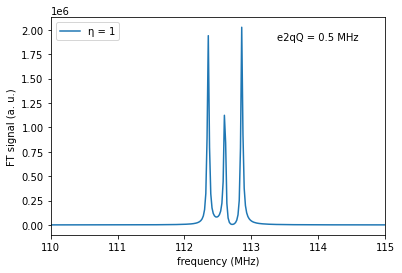

In [94]:
fig, ax = plt.subplots()
for eta, f, ft, t, fid in fts_magnus:
    plt.plot(f, np.absolute(ft)**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.xlim(110, 115)
plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")

plt.show()

Plot mesolve solution:

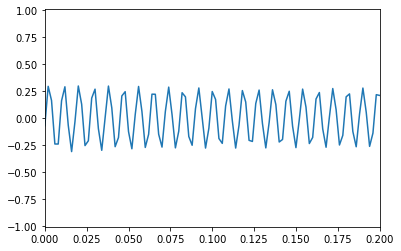

In [90]:
fig, ax = plt.subplots() 
for eta, f, ft, t, fid in fts_mesolve: 
	plt.plot(t, fid)

ax.set_xlim(0, 0.2)
fig.show()

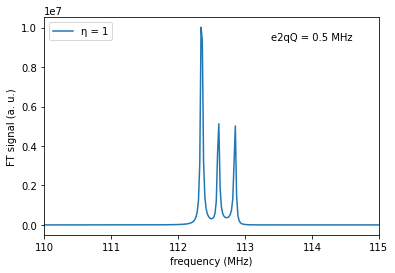

In [95]:
fig, ax = plt.subplots()
for eta, f, ft, t, fid in fts_mesolve:
    plt.plot(f, np.absolute(ft)**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.xlim(110, 115)
plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")

plt.show()


Plot exact diagonalization solution:

NameError: name 'fts_ed' is not defined

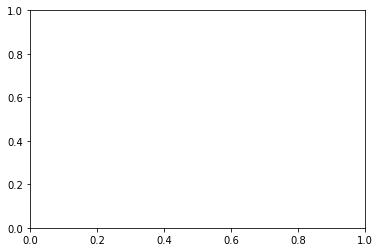

In [43]:
fig, ax = plt.subplots()
for eta, f, ft in fts_ed:
    plt.plot(f, np.absolute(ft)**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

# plt.xlim(-0.4, -.2)
plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")

plt.show()
